In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1250]:
from __future__ import print_function
import sys

sys.path.append('/reg/d/psdm/tmo/tmox51020/results/paris/')
sys.path.append('/reg/d/psdm/tmo/tmox51020/results/paris/recon')
import torch
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy as sc
import scipy.io as scio
from torch.autograd import Variable
from torch.autograd import grad
from torch import Tensor
import scipy.ndimage as scimg
from scipy.interpolate import interp1d
import sys
sys.path.append('/reg/neh/home/tdd14/modules/cart2pol/cart2pol')
import cart2pol
from cart2pol import PolarRebin
from torchrecon_funcs_cal_siqi2 import *
import os

In [2]:
####UPDATE FILENAMES##############
savefiledir = '/reg/d/psdm/tmo/tmoc00118/results/siqili/recon/' #where you are saving the output files
runnum = 286 #116 
#array of preprocessed images with shape (# shots, 64,64)
# mdat= np.load('/cds/home/p/paris/reconVMI_clean/recon X510 Dec/Ms_Mar12_112.npy', allow_pickle = True)[()]
mdatname='/reg/d/psdm/tmo/tmoc00118/results/siqili/data/streaked_ims_run_286.npy'
mdat= np.load(mdatname,allow_pickle=True)[()]
#array of preprocessed spectra with shape (# shots, 1024)
    # processing is:
        #smoothing with fastsmooth1 function and baseline subtraction
        #roll the spectra so that the central frequency of the average spectra (w0) is at the center of the array (pixel = 512) 
specdatname='/reg/d/psdm/tmo/tmoc00118/results/siqili/data/streaked_vls_processed_run_286.npy'
specdat = np.load(specdatname, allow_pickle = True)[()] 
pixpereV=6.9697054204683955#6.966300581474518#7.983037536410461#5.593817964009881
basesdir = '/reg/d/psdm/tmo/tmoc00118/results/siqili/basis_functions/'#Bpbasis_Up_0_to_0.5eV_filtered.npy'
PR = PolarRebin('/reg/d/psdm/tmo/tmox51020/results/paris/recon/PR_c32_r32_th32.h5')  # this should be correct for cart2pol, pol2cart for 64x64

In [3]:
######################
#update mask for your experiment
X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-512)**2+(Y-512)**2)
maskhm=np.zeros((1024,1024))
# maskhm[(rs>325-30) & (rs<420)]=1
maskhm[rs>1*120]=1#maskhm[rs>1*48]=1
mask = rebin(rebin(maskhm,4),4)

In [4]:
####################
Ups = [0.05]

#correction factor if the spectra calibration are off. 0 and 1 if calibration is correct
eshift = 0  
sc = 1

#smoothing applied to the vNbases image to try to make it match the measured
gfsig = 0.985 
gfcart = 0.25 
mfcart = 1

thresh = 0.0005 #small number to set everything below to zero for M/sum(M)

Bps = []
alphas = []
vNaxis = []

Np = 64#128
N_w=6#6
N_t=6#6 
hbar=6.6e-16 #eV*s
Nb=N_t*N_w


Up = Ups[0]  
# filename = 'Bpbasis_Np' + str(Np) + '_Nw' + str(N_w) +'_Nt' + str(N_t) + '_Up' + str(Up)+'.npy'
filename='Bpbasis_Up_'+str(Up)+'eV_Nt_6.npy'
Bp_basis = np.load(basesdir+filename, allow_pickle=True)
# Breal = br[()]['Breal']
# Bimag = br[()]['Bimag']
# breal = br[()]['breal']
# bimag = br[()]['bimag']
# vNaxis = br[()]['vNaxis']
# alpha = br[()]['alpha']
# Bp_basis = Breal+1j*Bimag

# #rebin to 64x64
# tempr = np.zeros((Breal.shape[0], 64**2))
# tempi = np.zeros((Breal.shape[0], 64**2))
# for i in range(len(Breal)):
#     tempr[i,:] = np.reshape(rebin(np.reshape(Breal[i,:], [128,128])), [64**2])
#     tempi[i,:] = np.reshape(rebin(np.reshape(Bimag[i,:], [128,128])), [64**2])

Breal = np.real(Bp_basis)
Bimag = np.imag(Bp_basis)

alpha_t_sample=np.load('/reg/d/psdm/tmo/tmoc00118/results/siqili/basis_functions/alpha_t_sample_Nt_6.npy')
vNaxis_t=np.load('/reg/d/psdm/tmo/tmoc00118/results/siqili/basis_functions/vNaxis_t_Nt_6.npy')
vNaxis_t_sample=np.load('/reg/d/psdm/tmo/tmoc00118/results/siqili/basis_functions/vNaxis_t_sample_Nt_6.npy')
vNaxis_w=np.load('/reg/d/psdm/tmo/tmoc00118/results/siqili/basis_functions/vNaxis_w_Nt_6.npy')



In [5]:
alphw = np.zeros(alpha_t_sample.shape, dtype = complex)
for i in range(len(alphw)):
    f = interp1d(vNaxis_t_sample, alpha_t_sample[i], fill_value = 0, bounds_error = False)
    N = 2801 #1024
    ts = np.linspace(vNaxis_t_sample[0],-vNaxis_t_sample[0], N)
    alphw[i] = np.fft.ifftshift(np.fft.ifft(f(ts)))


# alphw = np.zeros(alpha['t_sample'].shape, dtype = complex)
# for i in range(len(alphw)):
#     alphw[i] = np.fft.ifftshift(np.fft.ifft(alpha['t_sample'][i]))

alphaw_r=Variable(Tensor(np.real(alphw)))#real part
alphaw_i=Variable(Tensor(np.imag(alphw)))#imaginary part

In [6]:
Np = 64
for j in range(Breal.shape[0]):
    temp=np.reshape(Breal[j,:],[Np,Np])
    polimg = PR.cart2pol(temp,32,32)
    bb = np.zeros((64,64))
    bb[1:64,1:64]= PR.pol2cart(scimg.gaussian_filter(polimg,[gfsig,0]))
    Breal[j,:]=Variable(Tensor(np.reshape(bb*mask,newshape=(1,Np**2))))
    #temp=scimg.filters.gaussian_filter(temp,0.8889)
    #Bpr[j,:]=Variable(Tensor(np.reshape(temp,newshape=(1,Np**2))))
    temp=np.reshape(Bimag[j,:],[Np,Np])
    polimg = PR.cart2pol(temp,32,32)
    bb = np.zeros((64,64))
    bb[1:64,1:64]= PR.pol2cart(scimg.gaussian_filter(polimg,[gfsig,0]))
    Bimag[j,:]=Variable(Tensor(np.reshape(bb*mask,newshape=(1,Np**2))))
    #temp=scimg.filters.gaussian_filter(temp,0.8889)
    #Bpi[j,:]=Variable(Tensor(np.reshape(temp,newshape=(1,Np**2))))
    
Bpr=Variable(Tensor(Breal))
Bpi=Variable(Tensor(Bimag))

In [1323]:
t = 0
k= 0
tt = np.copy(t)

torch.manual_seed(t)

m = mdat[k]*mask
spec = specdat[k]
outdict = {}
outdict['thresh'] = thresh
outdict['gfsig'] = gfsig
outdict['gfcart'] = gfcart
# outdict['mfn'] = mfn
# outdict['gfn'] = gfn
outdict['eshift'] = eshift
outdict['sc'] = sc
outdict['mask'] = mask
outdict['maskhm'] = maskhm

M=Variable(Tensor(m))
M=M/torch.sum(M)
#M=M.transpose(0,1)
t=Variable(Tensor(vNaxis_t))
ts=Variable(Tensor(vNaxis_t_sample))
#ts=torch.linspace(t[0][0],t[0][-1],int(1e3))
w=Variable(Tensor(vNaxis_w))
alphat_r=Variable(Tensor(np.real(alpha_t_sample)))#real part
alphat_i=Variable(Tensor(np.imag(alpha_t_sample)))#imaginary part

N = 2801
xf = np.arange(-N/2-1/2,N/2-1/2,1)/np.abs(vNaxis_t_sample[0])/2
eV = 1239.84*(2*np.pi*xf)/2.9979E8/(2*np.pi)*1e-9 
#Interpolate spec outside of the loop to match eV axis of the vNbases
# xeV = pix_2_eV(np.arange(1024), pixpereV = 22, spectra_hw0 = 0, spectra_pix0 = 512)
eshift =  -8
xeV = pix_2_eV(np.arange(1024), pixpereV = pixpereV, spectra_hw0 = 0, spectra_pix0 = 512)
xeV = xeV - eshift #correction if calibration is off
f = interp1d(xeV,spec, bounds_error=False, fill_value = 0)
#spec_in = f(eV[1340:-1340])
spec_in = f(eV)

spec_in= Variable(Tensor(spec_in))
spec_in=spec_in/torch.max(spec_in)

# q = np.zeros((1,2*Nb-1))
q = np.zeros((1,2*Nb))
# q = np.zeros((1,1))
#q[0]=0.5
q[:,tt] = 1
q[:,-1] = -1
Q = Tensor(q)
# print(np.shape(q),tt,len(Q),Q)
Q.requires_grad = True
#Q.retain_grad()

n_epochs=1.3e3
lr=1e-2
optimizer=torch.optim.Adam([Q],lr=lr)
costs = []
costM = []
costW = []
costS = []
costQ = []
eps = []
M_wght = 1
Spec_wght = 100#10#12 #1 #0.75 #0.8
Smooth_wght = 0#0.00001
print(np.shape(Q))

torch.Size([1, 72])


In [1336]:
Q

tensor([[ 2.4920e-01,  6.2657e-02, -2.5591e-01,  6.4166e-01,  2.7991e-01,
          8.9592e-02, -7.2649e-02,  4.4501e-02,  2.2913e-02, -8.0692e-01,
         -2.5037e-01, -1.0524e-01,  5.8086e-02, -6.2851e-02,  4.7081e-01,
         -6.5389e-01,  3.1308e-02,  5.4693e-02,  6.7958e-02,  1.3647e-01,
          9.0057e-01, -2.7527e-03,  1.3070e-03, -2.3968e-02,  6.0054e-02,
         -7.5331e-02, -3.3362e-01,  9.0397e-02,  1.7664e-02,  1.5061e-02,
          8.0431e-02,  8.3084e-02,  1.0596e-01,  1.3905e-01,  1.6887e-02,
         -9.3802e-03, -1.5580e-01, -2.1659e-01,  5.3784e-01,  2.6771e-01,
          1.5141e-01,  7.0340e-02,  1.9627e-01,  3.2991e-01, -6.2904e-01,
         -4.5255e-01, -2.1046e-01, -1.6223e-02, -2.9959e-01, -9.3223e-01,
          1.0488e+00,  4.0268e-01,  1.7560e-01, -1.3069e-02,  1.5806e-01,
          1.4927e-01,  1.7806e-01, -1.4857e-01, -8.8076e-02, -4.1335e-02,
          3.3057e-02,  3.3834e-02,  2.4599e-01,  7.6504e-02,  4.1305e-02,
         -1.0747e-01, -1.4324e-01, -3.

In [1335]:
print(loss_tot_noQ(M,Q,Nb,Bpr,Bpi,spec_in, alphaw_r, alphaw_i,M_wght,Spec_wght,Smooth_wght,thresh))
#print(loss_w(spec_in, Q, alphaw_r, alphaw_i, Nb).detach().numpy()[()])
loss_tot_noQ(M,Q,Nb,Bpr,Bpi,spec_in, alphaw_r, alphaw_i,M_wght,Spec_wght,Smooth_wght,thresh).backward()
# print(loss_w_slide(spec_in, Q, alphaw_r, alphaw_i, Nb).detach().numpy()[()])
# loss_w_slide(spec_in, Q, alphaw_r, alphaw_i, Nb).backward()
#ll=loss_tot(M,Q,Nb,Bpr,Bpi,bkg,alpha_vn,ts,tn,wm,Nt,Nw,5,1,1)
#loss_tot(M,Q,Nb,Bpr,Bpi,bkg,alpha_vn,ts,tn,wm,Nt,Nw,5,1,1).backward()
optimizer.step()
optimizer.zero_grad()

tensor(30930.7715, grad_fn=<AddBackward0>)


In [1339]:
pwd

'/cds/home/p/paris/cVMI'

In [1332]:
for i in range(100):
    loss_tot_noQ(M,Q,Nb,Bpr,Bpi,spec_in, alphaw_r, alphaw_i,M_wght,Spec_wght,Smooth_wght,thresh).backward()
    # print(loss_w_slide(spec_in, Q, alphaw_r, alphaw_i, Nb).detach().numpy()[()])
    # loss_w_slide(spec_in, Q, alphaw_r, alphaw_i, Nb).backward()
    #ll=loss_tot(M,Q,Nb,Bpr,Bpi,bkg,alpha_vn,ts,tn,wm,Nt,Nw,5,1,1)
    #loss_tot(M,Q,Nb,Bpr,Bpi,bkg,alpha_vn,ts,tn,wm,Nt,Nw,5,1,1).backward()
    optimizer.step()
    optimizer.zero_grad()
    if i%10 == 0:
        print(i)

0
10
20
30
40
50
60
70
80
90


tensor(-15.3917, grad_fn=<MulBackward0>)


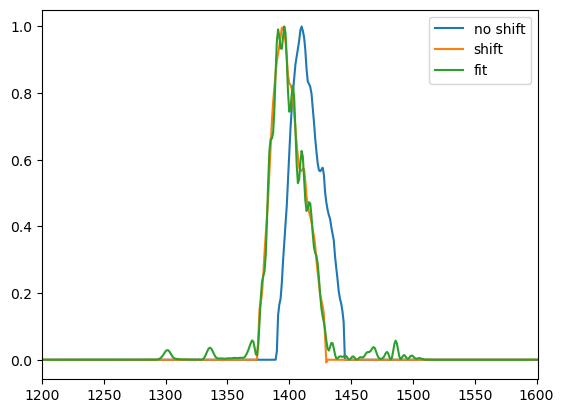

In [1337]:
q = np.zeros((1,2*Nb-1))
q[0][1]=1
Qq = Tensor(q)
Qr=Q[0][0:Nb]
#print(Qr)
#print(Q[0][-1])
Qr=Qr[None,:] #[1x36]
Qi=Q[0][Nb:2*Nb-1]
Qi=Qi[None,:]
x=Tensor([0])
Qi=torch.cat([x[:,None],Qi],1)
Qrt=torch.transpose(Qr,0,1)
Qit=torch.transpose(Qi,0,1)
eVshift = Q[0][-1]
eVshift=eVshift*10
print(eVshift)
#eVshift_idx = Tensor([eVshift*50])
#eVshift_idx.requires_grad= True

EwEw = (torch.mm(Qr,alphaw_r)-torch.mm(Qi,alphaw_i))**2+(torch.mm(Qr,alphaw_i)+torch.mm(Qi,alphaw_r))**2
#EwEwlook = Tensor(EwEw[0])#[1340:-1340])
#EwEwlook = Tensor(EwEw[0][1340-eVshift_idx:-1340-eVshift_idx])
EwEwlook = Tensor(EwEw[0])
EwEwlook=EwEwlook[None,:]
EwEwlook = EwEwlook/torch.max(EwEwlook)
w=Tensor(np.arange(len(EwEwlook[0])))
plt.plot(np.squeeze(spec_in.detach().numpy()[()]), label = 'no shift')
#spec = Tensor(spec_in[1340:-1340])
#spec = Tensor(spec_in[1200-eVshift_idx:-1200-eVshift_idx])
spec=interp(w,Tensor(spec_in),Tensor(w-eVshift))
plt.plot(np.squeeze(spec.detach().numpy()[()]), label = 'shift')
plt.plot(np.squeeze(EwEwlook.detach().numpy()[()]), label = 'fit')
plt.xlim(np.arange(2801)[1200],np.arange(2801)[-1200])
plt.legend()

In [1286]:
plt.figure(figsize=(14, 7))
plt.plot(losses,'.-')
print(m.Qs)

KeyboardInterrupt: 

<Figure size 1400x700 with 0 Axes>

In [790]:
np.squeeze(spec.detach().numpy()[()]).shape

(121,)

In [639]:
hm = Q[0][-1]
hm = (hm*50)
eV_idx = np.arange(2801)
eV_idx = Tensor(eV_idx)
hm

tensor(200., grad_fn=<MulBackward0>)

In [643]:
print(Q.grad)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [638]:
print(hm.grad)

None


In [367]:
eVshift_idx=torch.argmin((eV_idx-hm)**2)
eVshift_idx

tensor(9)

In [286]:
Q[0][-1]

tensor(0.2000, grad_fn=<SelectBackward0>)

In [61]:
############################
#loop through the images in preprocessed array
# for k in range(mdat.shape[0]):
for k in range(1):
    for t in range(1):
        tt = np.copy(t)
        savefilename = os.path.join(savefiledir, 'pytorchrecon_'+str(k)+'_Up'+str(Ups[0])+'_seed'+str(tt)+'.npy')
        if os.path.isfile(savefilename):
            print(savefilename+' exists')
            continue
        else:
            torch.manual_seed(t)
        
            m = mdat[k]*mask
            spec = specdat[k]
            outdict = {}
            outdict['thresh'] = thresh
            outdict['gfsig'] = gfsig
            outdict['gfcart'] = gfcart
            # outdict['mfn'] = mfn
            # outdict['gfn'] = gfn
            outdict['eshift'] = eshift
            outdict['sc'] = sc
            outdict['mask'] = mask
            outdict['maskhm'] = maskhm

            M=Variable(Tensor(m))
            M=M/torch.sum(M)
            #M=M.transpose(0,1)
            t=Variable(Tensor(vNaxis_t))
            ts=Variable(Tensor(vNaxis_t_sample))
            #ts=torch.linspace(t[0][0],t[0][-1],int(1e3))
            w=Variable(Tensor(vNaxis_w))
            alphat_r=Variable(Tensor(np.real(alpha_t_sample)))#real part
            alphat_i=Variable(Tensor(np.imag(alpha_t_sample)))#imaginary part

            N = 2801
            xf = np.arange(-N/2-1/2,N/2-1/2,1)/np.abs(vNaxis_t_sample[0])/2
            eV = 1239.84*(2*np.pi*xf)/2.9979E8/(2*np.pi)*1e-9 
            #Interpolate spec outside of the loop to match eV axis of the vNbases
            # xeV = pix_2_eV(np.arange(1024), pixpereV = 22, spectra_hw0 = 0, spectra_pix0 = 512)
            xeV = pix_2_eV(np.arange(1024), pixpereV = pixpereV, spectra_hw0 = 0, spectra_pix0 = 512)
            xeV = xeV - eshift #correction if calibration is off
            f = interp1d(xeV,spec, bounds_error=False, fill_value = 0)
            spec_in = f(eV[1340:-1340])
            
            spec_in= Variable(Tensor(spec_in))
            spec_in=spec_in/torch.max(spec_in)

            # q = np.zeros((1,2*Nb-1))
            q = np.zeros((1,2*Nb))
            q[0][-1]=2
            q[:,tt] = 1
            Q = Tensor(q)
            # print(np.shape(q),tt,len(Q),Q)
            Q.requires_grad = True
            
            n_epochs=1.3e3
            lr=1e-2
            optimizer=torch.optim.Adam([Q],lr=lr)
            costs = []
            costM = []
            costW = []
            costS = []
            costQ = []
            eps = []
            M_wght = 1
            Spec_wght = 10#12 #1 #0.75 #0.8
            Smooth_wght = 10#0.00001
            print(np.shape(Q))
            for epoch in range(int(n_epochs)):
                
                ll=loss_tot_noQ(M,Q,Nb,Bpr,Bpi,spec_in, alphaw_r, alphaw_i,M_wght,Spec_wght,Smooth_wght,thresh)
                loss_tot_noQ(M,Q,Nb,Bpr,Bpi,spec_in, alphaw_r, alphaw_i,M_wght,Spec_wght,Smooth_wght,thresh).backward()
                #ll=loss_tot(M,Q,Nb,Bpr,Bpi,bkg,alpha_vn,ts,tn,wm,Nt,Nw,5,1,1)
                #loss_tot(M,Q,Nb,Bpr,Bpi,bkg,alpha_vn,ts,tn,wm,Nt,Nw,5,1,1).backward()
                optimizer.step()
                optimizer.zero_grad()
                if epoch%100==0:
                    #print(epoch,'total loss = '+str(ll),str(Q[0][0]))
                    costs.append(ll.detach().numpy()[()])
                    costM.append(loss_M(M,Q,Nb,Bpr,Bpi,thresh).detach().numpy()[()]*M_wght)
                    costW.append(loss_w(spec_in, Q, alphaw_r, alphaw_i, Nb).detach().numpy()[()]*Spec_wght)
                    #costS.append(loss_w_smooth(Q, alphaw_r, alphaw_i, Nb).detach().numpy()[()]*Smooth_wght)
                    #costQ.append(0.1*loss_Q(Q,Nb).detach().numpy()[()])
                    costS.append(0)
                    costQ.append(0)
                    eps.append(epoch)
                if ll < lr:
                    break


torch.Size([1, 72])
tensor(0, dtype=torch.int32)


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [27]:
Q[0]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.],
       grad_fn=<SelectBackward0>)

In [28]:
loss_w(spec_in, Q, alphaw_r, alphaw_i, Nb)

tensor(20590.8516, grad_fn=<AddBackward0>)

In [29]:
loss_tot_noQ(M,Q,Nb,Bpr,Bpi,spec_in, alphaw_r, alphaw_i,M_wght,Spec_wght,Smooth_wght,thresh)

tensor(279348.0625, grad_fn=<AddBackward0>)

In [15]:
def loss_w_s(spec, Q, alphaw_r, alphaw_i, Nb):
    #spec is already smoothed, baseline subtracted and zero thresholded
    print('hi')
    Qr=Q[0][0:Nb]
    Qr=Qr[None,:] #[1x36]
    Qi=Q[0][Nb:2*Nb-1]
    Qi=Qi[None,:]
    x=Tensor([0])
    Qi=torch.cat([x[:,None],Qi],1)
    Qrt=torch.transpose(Qr,0,1)
    Qit=torch.transpose(Qi,0,1)
    eVshift = 20#Q[0][-1]
    eVshift_idx = int(eVshift*50)
    EwEw = (torch.mm(Qr,alphaw_r)-torch.mm(Qi,alphaw_i))**2+(torch.mm(Qr,alphaw_i)+torch.mm(Qi,alphaw_r))**2
    if eVshift_idx>1340: 
        eVshift_idx=40
    if eVshift_idx<-1340:
        eVshift_idx=-40
    print(eVshift_idx)
    plt.figure()
    EwEwlooktest=Tensor(EwEw[0][1340-0:-1340-0])
    EwEwlook = Tensor(EwEw[0][1340-eVshift_idx:-1340-eVshift_idx])
    print(np.shape(EwEw[0]))
    plt.plot(EwEwlooktest.detach().numpy())
    plt.plot(EwEwlook.detach().numpy())
    plt.show()
    EwEwlook=EwEwlook[None,:]
    EwEwlook = EwEwlook/torch.max(EwEwlook)
    #EwEwlook = EwEwlook*12.5
    #spec = spec*12.5
    return torch.sum(torch.abs(14*(EwEwlook-spec))**2) + torch.sum(torch.abs(2*(EwEwlook-spec)/(spec+0.1))**2)


hi
1000
torch.Size([2801])


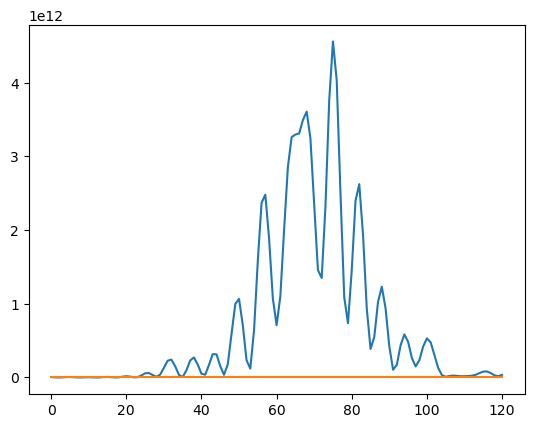

tensor(8994.4561, grad_fn=<AddBackward0>)

In [16]:
loss_w_s(spec_in, Q, alphaw_r, alphaw_i, Nb)

ValueError: only one element tensors can be converted to Python scalars

In [84]:
#setup parameters
N_w=8
N_t=8#vN lattice points in time and frequency
N_basis=N_w*N_t;
Np=64#image size
hbar=6.6e-16;#in ev*s
Ttot=10e-15;#total time for integration in s
energy_x=80#xray energy in eV
# Up=0.1#eV
# I_A=np.sqrt(4*Up/27.2);#au,streaking laser vector potential strength, in a.u.. NOT U_p!!!
tau_l=800e-9/3e8;#streaking laser period in s
Kmax=0.001249*512**2/27.2#defines the max energy on the edge of the detector, in au
T=tau_l#range for vN time axis
if energy_x<100:
    alpha, vNaxis, temp=vN.vNbasis_nonlinear(T, N_w, N_t,200,2000,1000,Ttot);
else:
    alpha, vNaxis, temp=vN.vNbasis_nonlinear(T, N_w, N_t,400,4000,2000,Ttot);
alpha_tdata=alpha['t_sample']
alpha_tdata=alpha_tdata/np.max(np.abs(alpha_tdata))
alpha_t_sample=alpha_tdata
vNaxis_t_sample=vNaxis['t_sample']

In [85]:
Up = Ups 
# filename = 'Bpbasis_Np' + str(Np) + '_Nw' + str(N_w) +'_Nt' + str(N_t) + '_Up' + str(Up)+'.npy'
filename='Bpbasis_Up_'+str(Up)+'eV.npy'
Bp_basis = np.load(basesdir+filename, allow_pickle=True)
Breal = np.real(Bp_basis)
Bimag = np.imag(Bp_basis)

# alpha_t_sample=np.load('/reg/d/psdm/tmo/tmoc00118/results/siqili/basis_functions/alpha_t_sample.npy')
# vNaxis_t=np.load('/reg/d/psdm/tmo/tmoc00118/results/siqili/basis_functions/vNaxis_t.npy')
# vNaxis_t_sample=np.load('/reg/d/psdm/tmo/tmoc00118/results/siqili/basis_functions/vNaxis_t_sample.npy')
# vNaxis_w=np.load('/reg/d/psdm/tmo/tmoc00118/results/siqili/basis_functions/vNaxis_w.npy')

alphw = np.zeros(alpha_t_sample.shape, dtype = complex)
for i in range(len(alphw)):
    f = interp1d(vNaxis_t_sample, alpha_t_sample[i], fill_value = 0, bounds_error = False)
    N = 2801 #1024
    ts = np.linspace(vNaxis_t_sample[0],-vNaxis_t_sample[0], N)
    alphw[i] = np.fft.ifftshift(np.fft.ifft(f(ts)))

Bpr=Variable(Tensor(Breal))
Bpi=Variable(Tensor(Bimag))

In [86]:
k=1
t=0

tt = np.copy(t)
savefilename = os.path.join(savefiledir, 'pytorchrecon_'+str(k)+'_Up'+str(Ups)+'_seed'+str(tt)+'.npy')
if os.path.isfile(savefilename):
    print(savefilename+' exists')
else:
    torch.manual_seed(t)
        
    m = mdat[k]*mask
    spec = specdat[k]


    M=Variable(Tensor(m))
    M=M/torch.sum(M)
            #M=M.transpose(0,1)
    t=Variable(Tensor(vNaxis_t))
    ts=Variable(Tensor(vNaxis_t_sample))
            #ts=torch.linspace(t[0][0],t[0][-1],int(1e3))
    w=Variable(Tensor(vNaxis_w))
    alphat_r=Variable(Tensor(np.real(alpha_t_sample)))#real part
    alphat_i=Variable(Tensor(np.imag(alpha_t_sample)))#imaginary part

    N = 2801
    xf = np.arange(-N/2-1/2,N/2-1/2,1)/np.abs(vNaxis_t_sample[0])/2
    eV = 1239.84*(2*np.pi*xf)/2.9979E8/(2*np.pi)*1e-9 
            #Interpolate spec outside of the loop to match eV axis of the vNbases
            # xeV = pix_2_eV(np.arange(1024), pixpereV = 22, spectra_hw0 = 0, spectra_pix0 = 512)
    xeV = pix_2_eV(np.arange(1024), pixpereV = 4.692055975830744, spectra_hw0 = 0, spectra_pix0 = 512)
    xeV = xeV - eshift #correction if calibration is off
    f = interp1d(xeV,spec, bounds_error=False, fill_value = 0)
    spec_in = f(eV[1340:-1340])
            
    spec_in= Variable(Tensor(spec_in))
    spec_in=spec_in/torch.max(spec_in)

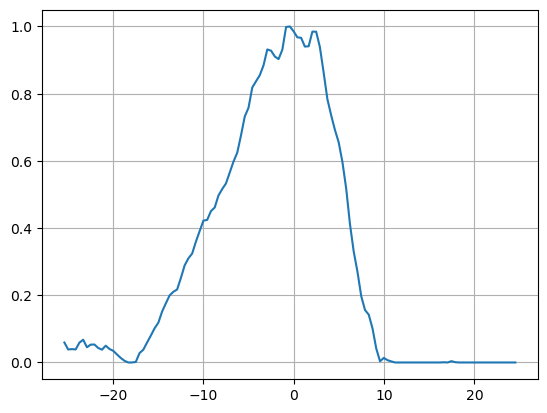

In [87]:
plt.plot(eV[1340:-1340],spec_in)
plt.grid()

In [127]:
Ups = 0.0

#correction factor if the spectra calibration are off. 0 and 1 if calibration is correct
eshift = 0  
sc = 1

#smoothing applied to the vNbases image to try to make it match the measured
gfsig = 0.5#0.985 
gfcart = 0.1#0.25 
mfcart = 1

thresh = 0.0005 #small number to set everything below to zero for M/sum(M)

Bps = []
alphas = []
vNaxis = []

Np = 64#128
N_w=8#6
N_t=8#6 
hbar=6.6e-16 #eV*s
Nb=N_t*N_w

In [128]:
Up = Ups  
# filename = 'Bpbasis_Np' + str(Np) + '_Nw' + str(N_w) +'_Nt' + str(N_t) + '_Up' + str(Up)+'.npy'
filename='Bpbasis_Up_'+str(Up)+'eV.npy'
Bp_basis = np.load(basesdir+filename, allow_pickle=True)
np.shape(Bp_basis)

(4096, 4096)

In [129]:
Breal = np.real(Bp_basis)
Bimag = np.imag(Bp_basis)

alpha_t_sample=np.load('/reg/d/psdm/tmo/tmoc00118/results/siqili/basis_functions/alpha_t_sample.npy')
vNaxis_t=np.load('/reg/d/psdm/tmo/tmoc00118/results/siqili/basis_functions/vNaxis_t.npy')
vNaxis_t_sample=np.load('/reg/d/psdm/tmo/tmoc00118/results/siqili/basis_functions/vNaxis_t_sample.npy')
vNaxis_w=np.load('/reg/d/psdm/tmo/tmoc00118/results/siqili/basis_functions/vNaxis_w.npy')

alphw = np.zeros(alpha_t_sample.shape, dtype = complex)
for i in range(len(alphw)):
    f = interp1d(vNaxis_t_sample, alpha_t_sample[i], fill_value = 0, bounds_error = False)
    N = 2801 #1024
    ts = np.linspace(vNaxis_t_sample[0],-vNaxis_t_sample[0], N)
    alphw[i] = np.fft.ifftshift(np.fft.ifft(f(ts)))


In [130]:
alphaw_r=Variable(Tensor(np.real(alphw)))#real part
alphaw_i=Variable(Tensor(np.imag(alphw)))#imaginary part

Np = 64
for j in range(Breal.shape[0]):
    temp=np.reshape(Breal[j,:],[Np,Np])
    polimg = PR.cart2pol(temp,32,32)
    bb = np.zeros((64,64))
    bb[1:64,1:64]= PR.pol2cart(scimg.gaussian_filter(polimg,[gfsig,0]))
    Breal[j,:]=Variable(Tensor(np.reshape(bb*mask,newshape=(1,Np**2))))
    #temp=scimg.filters.gaussian_filter(temp,0.8889)
    #Bpr[j,:]=Variable(Tensor(np.reshape(temp,newshape=(1,Np**2))))
    temp=np.reshape(Bimag[j,:],[Np,Np])
    polimg = PR.cart2pol(temp,32,32)
    bb = np.zeros((64,64))
    bb[1:64,1:64]= PR.pol2cart(scimg.gaussian_filter(polimg,[gfsig,0]))
    Bimag[j,:]=Variable(Tensor(np.reshape(bb*mask,newshape=(1,Np**2))))
    #temp=scimg.filters.gaussian_filter(temp,0.8889)
    #Bpi[j,:]=Variable(Tensor(np.reshape(temp,newshape=(1,Np**2))))
    
Bpr=Variable(Tensor(Breal))
Bpi=Variable(Tensor(Bimag))

In [131]:
Bp=Bpr+1j*Bpi

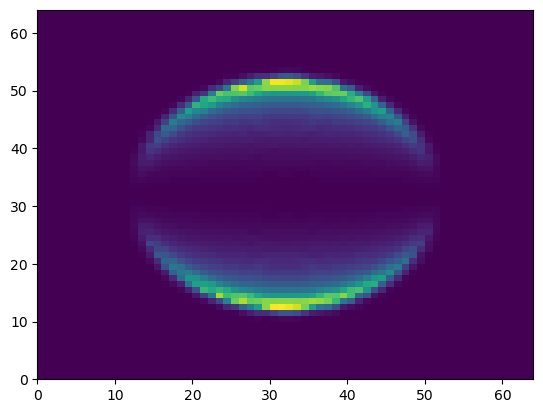

In [132]:
plt.pcolormesh(np.abs(np.reshape(Bp[0,:],[64,64])))

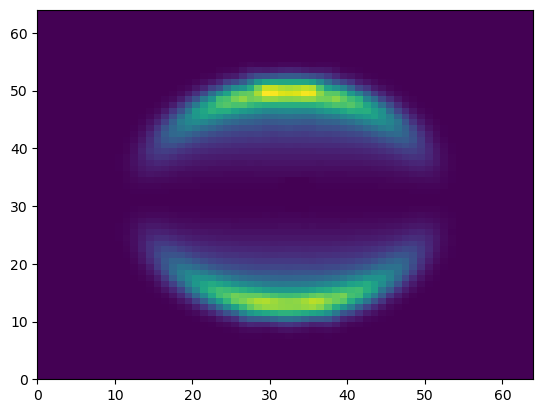

In [27]:
plt.pcolormesh(np.abs(np.reshape(Bp[0,:],[64,64])))

In [28]:
import h5py

In [56]:
d=h5py.File('/reg/d/psdm/tmo/tmoc00118/hdf5/smalldata/tmoc00118_Run0469.h5','r')

In [57]:
d.keys()

<KeysViewHDF5 ['Sample', 'Sums', 'UserDataCfg', 'andor', 'epics', 'epicsAll', 'hsd', 'lightStatus', 'retardationVoltages', 'timestamp', 'timing']>

In [64]:
dd=np.array(d['epicsAll']['vls_camera_pitch'])
d['epicsAll'].keys()

<KeysViewHDF5 ['AT1K0_PressureSetPt', 'AT1K0_VCN70_PosReq', 'AT1K0_actual_GasAttenTrans', 'AT1K0_photon_energy', 'AT1K0_set_GasAttenTrans', 'GMD_CrossSection', 'GMD_ElectronFaradayCup', 'GMD_ElectronMesh', 'GMD_ElectronMultiplier', 'GMD_IonMesh', 'GMD_Keithley_Sum', 'GMD_MeanCharge', 'GMD_PressureCalc', 'GMD_Temp_rbv', 'IM2K4_XrayPower', 'IM3K4_XrayPower', 'IM4K4_XrayPower', 'IM5K4_XrayPower', 'Keithley_1_xgmd', 'Keithley_2_xgmd', 'Keithley_gmd', 'MR1K4_pitch', 'MR1K4_xup', 'MR1K4_yup', 'MR2K4_bender_ds', 'MR2K4_bender_us', 'MR2K4_pitch', 'MR2K4_x', 'MR2K4_y', 'MR3K4_bender_ds', 'MR3K4_bender_us', 'MR3K4_pitch', 'MR3K4_x', 'MR3K4_y', 'Machine', 'PF1K4_y', 'PF1K4_z', 'Port_0_Anode', 'Port_0_Back_Mesh', 'Port_0_Blade_22', 'Port_0_Blade_25', 'Port_0_Front_Mesh', 'Port_0_MCP_Back', 'Port_0_MCP_Front', 'Port_0_Nose', 'Port_12_Anode', 'Port_12_Back_Mesh', 'Port_12_Blade_22', 'Port_12_Blade_25', 'Port_12_Front_Mesh', 'Port_12_MCP_Back', 'Port_12_MCP_Front', 'Port_12_Nose', 'Port_13_Anode', 'P

In [88]:
1+1

2

In [107]:
N = 2801
spec = specdat[0]
xf = np.arange(-N/2-1/2,N/2-1/2,1)/np.abs(vNaxis_t_sample[0])/2
eV = 1239.84*(2*np.pi*xf)/2.9979E8/(2*np.pi)*1e-9 
            #Interpolate spec outside of the loop to match eV axis of the vNbases
            # xeV = pix_2_eV(np.arange(1024), pixpereV = 22, spectra_hw0 = 0, spectra_pix0 = 512)
xeV = pix_2_eV(np.arange(500), pixpereV = 29.47114275748641, spectra_hw0 = 0, spectra_pix0 = 250)
xeV = xeV - eshift #correction if calibration is off
f = interp1d(xeV,spec, bounds_error=False, fill_value = 0)
spec_in = f(eV[1340:-1340])

In [ ]:
sbatch -p psanaq --nodes 2 --ntasks-per-node 3 --wrap="mpirun python itorch_recon_clean_siqi.py 0.05"

In [9]:
%run itorch_recon_clean_siqi.py 0

(72,)
(72,)
(72,)


In [10]:
%run itorch_recon_clean_siqi.py 0.05

(72,)
(72,)


In [11]:
%run itorch_recon_clean_siqi.py 0.1

(72,)
(72,)
(72,)


In [12]:
%run itorch_recon_clean_siqi.py 0.15

(72,)
(72,)
(72,)


In [17]:
#update mask for your experiment
X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-512)**2+(Y-512)**2)
maskhm=np.zeros((1024,1024))
# maskhm[(rs>325-30) & (rs<420)]=1
maskhm[rs>1*120]=1
mask = rebin(rebin(maskhm,4),4)

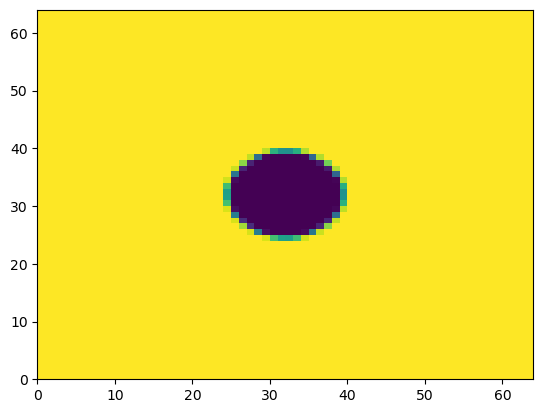

In [18]:
plt.pcolormesh(mask)